In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import networkx as nx
import pywavefront
import time
import pandas as pd

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

from optimizers import KFACOptimizer
import torch_optimizer as optim

In [6]:
#define a graph with boundary conditions

n = 50
G_grid = nx.grid_graph([n,n], periodic = False)
#G= nx.random_geometric_graph(n**2, .04)
#G= nx.erdos_renyi_graph(n**2, .004)

mapping = { i:en for en, i in enumerate(G_grid.nodes)}
G = nx.relabel_nodes(G_grid, mapping)
print(nx.info(G))

hot_id = list(G.nodes)[:2*n]
cold_id = list(G.nodes)[-2*n:]


print(len(hot_id))
print(len(cold_id))

Name: 
Type: Graph
Number of nodes: 2500
Number of edges: 4900
Average degree:   3.9200
100
100


In [8]:
#sparse adjacency matrix

N = len(G.nodes)

edg = []
for i in G.edges():
    edg += [[i[0], i[1]]]
    edg += [[i[1], i[0]]]
    
values = list(ones(len(edg)))

A_sp = torch.sparse_coo_tensor(list(zip(*edg)), values, (N, N),dtype=torch.float32)

In [9]:
A_sp

tensor(indices=tensor([[   0,   50,    0,  ..., 2498, 2498, 2499],
                       [  50,    0,    1,  ..., 2497, 2499, 2498]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(2500, 2500), nnz=9800, layout=torch.sparse_coo)

In [10]:
#set up a propagation rule DAD, DA, A
def normalize_A(A, prop_rule = None):
    N = len(A)
    identity_N = [[i,i] for i in range(N)]
    values_N = list(ones(N))
    I = torch.sparse_coo_tensor(list(zip(*identity_N)), values_N, (N, N))
    
    A_norm = A + I
    
    if prop_rule == None or prop_rule == 'A':
        return A_norm
    else:
        D = torch.sparse.sum(A_norm, dim= 0).values()
        
        if prop_rule == 'D':
            D_1 = torch.sparse_coo_tensor(list(zip(*identity_N)), 1/D, (N, N))
            return torch.sparse.mm(D_1, A_norm)
        
        if prop_rule == 'DAD':
            D_half = torch.sparse_coo_tensor(list(zip(*identity_N)), 1/sqrt(D), (N, N))
            return torch.sparse.mm(torch.sparse.mm(D_half, A_norm), D_half)
        

In [11]:
#sparse laplacian
identity_N = [[i,i] for i in range(N)]
D =  torch.sparse_coo_tensor(list(zip(*identity_N)), torch.sparse.sum(A_sp, dim= 0).values(), (N, N), dtype=torch.float32)  
L = D - A_sp
L

tensor(indices=tensor([[   0,    0,    1,  ..., 2498, 2499, 2499],
                       [   0,   50,    1,  ..., 2499, 2498, 2499]]),
       values=tensor([ 2., -1.,  3.,  ..., -1., -1.,  2.]),
       size=(2500, 2500), nnz=12300, layout=torch.sparse_coo)

In [12]:
I_sp = torch.sparse_coo_tensor(list(zip(*identity_N)), torch.ones(N), (N, N), dtype=torch.float32)  

In [13]:
#for measuring time
def time_it(f):
    def dt(*args, **kw):
        t0 = time.time()
        a = f(*args, **kw)
        t = time.time()-t0
        print('%s time: %.3g s'%(f.__name__,t))
        return t
    return dt

In [14]:
#loss function: heat equation

hot = 10
cold =  -10
c = 4

def Loss(X):
    
    cold_X = X[cold_id]
    hot_X = X[hot_id] 
    
    #V = torch.sum(torch.spmm(L,X)*X)
     
    V = torch.sum((L@X)*X)
     
    Reg = torch.sum((cold_X - cold)**c)   + torch.sum((hot_X - hot)**c )
    
    return V + Reg

In [16]:
#GCN reparametrization

class GCN(nn.Module):
    def __init__(self, in_feat, out_feat, A):
        super(GCN, self).__init__()
        self.in_feat = in_feat
        self.A = A
        self.out_feat = out_feat
        
        self.W = nn.Parameter(torch.empty(in_feat, out_feat))
        nn.init.kaiming_normal_(self.W) 
        
    def forward(self, x):
        return  self.A @ x @ self.W
        #return torch.spmm(self.A, torch.spmm(x, self.W))

In [17]:
#linear reparametrization
class Deep(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(Deep, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        
        self.W = nn.Parameter(torch.empty(in_feat, out_feat))
        nn.init.kaiming_normal_(self.W) 
        
    def forward(self, x):
        return x @ self.W

In [18]:
#neural network model with residual connection
class neuralHeat_Res(nn.Module):
    def __init__(self,  feat_dims = [1,1] , A = None, deepfdl = False, fdl = False, propagation_rule = 'DAD', lr = 0.01):  #feat dims [latent_1,....,latent_n-1, latent_n, out]
        super(neuralHeat_Res, self).__init__()
        self.deepfdl = deepfdl
        self.A = normalize_A(A, propagation_rule)
        
        n = len(self.A)
        
        self.latent = nn.Parameter(torch.empty(n, feat_dims[0]))
        r = n**(1./feat_dims[0])
        nn.init.normal_(self.latent,std = r)
        #nn.init.uniform_(self.latent,a=0.0, b=2*pi)
       
        self.Loss = lambda x: Loss(x)
        
        self.gcn_list = nn.ModuleList([GCN(feat_dims[i], feat_dims[i+1], A=self.A.float()) for i in range(len(feat_dims)-2)])
        
        self.deep_list = nn.ModuleList([Deep(feat_dims[i], feat_dims[i+1]) for i in range(len(feat_dims)-2)])
        
        
        self.nonlinearity = nn.ReLU()
        
        
        self.projection = nn.Parameter(torch.empty( sum(feat_dims[:-1]), feat_dims[-1] ))
        nn.init.normal_(self.projection,std = r)
        
        self.loss_history = []
        self.optim = torch.optim.Adam(self.parameters(), lr = lr)
        
        self.fine_pos = nn.Parameter(torch.empty(n,feat_dims[-1]))
        nn.init.normal_(self.fine_pos,std = r)
        #nn.init.uniform_(self.fine_pos, a=0.0, b=2*pi)
        
        self.optim_fine = torch.optim.Adam([self.fine_pos], lr = lr)
        #self.optim_fine = torch.optim.SGD([self.fine_pos], lr = lr)
        #self.optim_fine = torch.optim.RMSprop([self.fine_pos], lr = lr)
        #self.optim_fine = optim.Shampoo([self.fine_pos], lr = lr)
    
    def forward(self,):
        if self.deepfdl == False:       
            out = [self.latent]
            for g in self.gcn_list:
                out += [self.nonlinearity(g(out[-1]))]
            out = torch.concat(out,dim = 1)
      
            return out @ self.projection
        else:
            out = [self.latent]
            for g in self.deep_list:
                out += [self.nonlinearity(g(out[-1]))]
            out = torch.concat(out,dim = 1)
      
            return out @ self.projection
    
    
        
    @time_it
    def train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 100, min_steps=100, stop_delta_ratio = 5e-3, gcn_stop_threshold = 2e-2, fdl_stop_threshold = 5e-3,
              **stop_kws):
        """train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 100, 
              min_steps=100, #stop_delta_ratio = 5e-3, 
              gcn_stop_threshold = 2e-2,
              fdl_stop_threshold = 5e-3,
              **stop_kws):
        """
        try:
            if gcn_steps > 0 and len(self.gcn_list) > 0:
                self.train_reparametrization(steps=gcn_steps, early_stop_check=early_stop_check_steps, 
                               min_steps=min_steps, 
                               stop_delta_ratio=gcn_stop_threshold, **stop_kws)
                self.fine_pos.data = self()
            print(f'\nFDL training {fdl_steps} steps')
            self.train_fine(steps=fdl_steps, early_stop_check=early_stop_check_steps, 
                            min_steps=min_steps, 
                            stop_delta_ratio=fdl_stop_threshold, **stop_kws)
        except KeyboardInterrupt:
            print('\nTraining interrupted')
            return
        
    
    @time_it
    def train_reparametrization(self,steps = 100, early_stop_check = 100, min_steps=100, stop_delta_ratio = 5e-3, **stop_kws):
        for i in range(steps):
            self.optim.zero_grad()
            loss = self.Loss(self())
            loss.backward() 
            self.loss_history += [loss.item()+0.]
            self.optim.step()
            if i> min_steps and i % early_stop_check == 1:
                # print('checking', i)
                if early_stopping(self.loss_history,stop_delta_ratio=stop_delta_ratio, **stop_kws): 
                    print('\n===========\nstopping at step ',i)
                    break
    
    @time_it    
    def train_fine(self,steps = 100, early_stop_check = 100, min_steps=100, stop_delta_ratio = 5e-3, **stop_kws):
        for i in range(steps):
            self.optim_fine.zero_grad()
            # loss = Loss(self.fine_pos, self.A)
            loss = self.Loss(self.fine_pos)
            loss.backward() 
            self.loss_history += [loss.item()+0.]
            self.optim_fine.step()
            if i> min_steps and i % early_stop_check == 1:
                # print('checking', i)
                if early_stopping(self.loss_history,stop_delta_ratio=stop_delta_ratio, **stop_kws): 
                    print('\n===========\nstopping at step ',i)
                    break
                    
    def running_time(self):
        return time_it()          
    def get_node_pos(self):
        return self.fine_pos


In [19]:
#neural network model without residual connection
class neuralHeat(nn.Module):
    def __init__(self,  feat_dims = [1,1] , A = None, deepfdl = False, fdl = False, propagation_rule = 'DAD', lr = 0.01):  #feat dims [latent_1,....,latent_n-1, latent_n, out]
        super(neuralHeat, self).__init__()
        self.deepfdl = deepfdl
        self.A = normalize_A(A, propagation_rule)
        
        n = len(self.A)
        
        self.latent = nn.Parameter(torch.empty(n, feat_dims[0]))
        r = n**(1./feat_dims[0])
        nn.init.normal_(self.latent,std = r)
        #nn.init.uniform_(self.latent,a=0.0, b=2*pi)
       
        self.Loss = lambda x: Loss(x)
        
        self.gcn_list = nn.ModuleList([GCN(feat_dims[i], feat_dims[i+1], A=self.A.float()) for i in range(len(feat_dims)-2)])
        
        self.deep_list = nn.ModuleList([Deep(feat_dims[i], feat_dims[i+1]) for i in range(len(feat_dims)-2)])
        
        
        self.nonlinearity = nn.ReLU()
        
        
        self.projection = nn.Parameter(torch.empty( feat_dims[-2], feat_dims[-1] ))
        nn.init.normal_(self.projection,std = r)
        
        self.loss_history = []
        self.optim = torch.optim.Adam(self.parameters(), lr = lr)
        
        self.fine_pos = nn.Parameter(torch.empty(n,feat_dims[-1]))
        nn.init.normal_(self.fine_pos,std = r)
        #nn.init.uniform_(self.fine_pos, a=0.0, b=2*pi)
        
        self.optim_fine = torch.optim.Adam([self.fine_pos], lr = lr)
        #self.optim_fine = torch.optim.SGD([self.fine_pos], lr = lr)
        #self.optim_fine = torch.optim.RMSprop([self.fine_pos], lr = lr)
        #self.optim_fine = optim.Shampoo([self.fine_pos], lr = lr)
    
    def forward(self,):
        if self.deepfdl == False:       
            out = self.latent
            for g in self.gcn_list:
                out = self.nonlinearity(g(out))
      
            return out  @ self.projection
        else:
            out = self.latent
            for g in self.deep_list:
                out = self.nonlinearity(g(out))
            
            return out @ self.projection
    
        
    @time_it
    def train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 100, min_steps=100, stop_delta_ratio = 5e-3, gcn_stop_threshold = 2e-2, fdl_stop_threshold = 5e-3,
              **stop_kws):
        """train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 100, 
              min_steps=100, #stop_delta_ratio = 5e-3, 
              gcn_stop_threshold = 2e-2,
              fdl_stop_threshold = 5e-3,
              **stop_kws):
        """
        try:
            if gcn_steps > 0 and len(self.gcn_list) > 0:
                self.train_reparametrization(steps=gcn_steps, early_stop_check=early_stop_check_steps, 
                               min_steps=min_steps, 
                               stop_delta_ratio=gcn_stop_threshold, **stop_kws)
                self.fine_pos.data = self()
            print(f'\nFDL training {fdl_steps} steps')
            self.train_fine(steps=fdl_steps, early_stop_check=early_stop_check_steps, 
                            min_steps=min_steps, 
                            stop_delta_ratio=fdl_stop_threshold, **stop_kws)
        except KeyboardInterrupt:
            print('\nTraining interrupted')
            return
        
    
    @time_it
    def train_reparametrization(self,steps = 100, early_stop_check = 100, min_steps=100, stop_delta_ratio = 5e-3, **stop_kws):
        for i in range(steps):
            self.optim.zero_grad()
            loss = self.Loss(self())
            loss.backward() 
            self.loss_history += [loss.item()+0.]
            self.optim.step()
            if i> min_steps and i % early_stop_check == 1:
                # print('checking', i)
                if early_stopping(self.loss_history,stop_delta_ratio=stop_delta_ratio, **stop_kws): 
                    print('\n===========\nstopping at step ',i)
                    break
    
    @time_it    
    def train_fine(self,steps = 100, early_stop_check = 100, min_steps=100, stop_delta_ratio = 5e-3, **stop_kws):
        for i in range(steps):
            self.optim_fine.zero_grad()
            # loss = Loss(self.fine_pos, self.A)
            loss = self.Loss(self.fine_pos)
            loss.backward() 
            self.loss_history += [loss.item()+0.]
            self.optim_fine.step()
            if i> min_steps and i % early_stop_check == 1:
                # print('checking', i)
                if early_stopping(self.loss_history,stop_delta_ratio=stop_delta_ratio, **stop_kws): 
                    print('\n===========\nstopping at step ',i)
                    break
                    
    def running_time(self):
        return time_it()          
    def get_node_pos(self):
        return self.fine_pos

In [20]:
#early stopping condition

def early_stopping(metric_list,
            small_window = 32, #
            big_window = 1000,#1000, # 4 times of the small window
            stop_delta_ratio = 1e-3, verbose=True):
    if len(metric_list) < 2*small_window:
        return False
    # check if chenges within big window and small window are smaller then the ratio
    big_window = max(big_window, 2*small_window)
    last = mean(metric_list[-small_window:])
    dl_small =  abs(last - mean(metric_list[-2*small_window:-small_window]))
    idx = max(0,len(metric_list)-big_window)
    dl_big = abs(last - mean(metric_list[idx:idx+small_window]))
    ratio = dl_small / dl_big
    if verbose: 
        print(f'step: {len(metric_list)}, Loss change ratio: {ratio:.3g}', end='\r')
        # print(f'Loss change ratio: {ratio:.3g}', end='\r')
        
    return (ratio < stop_delta_ratio) or (dl_small < 1e-2)

def plot_layout(res):
    x = res.get_node_pos()
    
    plot(x.detach().numpy())

In [21]:
# choose GCN small steps
MAX_GCN_STEPS = int(2e4)

# fine-tuning FDL steps. make large
MAX_FDL_STEPS = int(2e5)

# early stopping (lower = runs longer)
GCN_STOP_THRESHOLD = 5e-4
FDL_STOP_THRESHOLD = 1e-3



step: 142, Loss change ratio: 0.000341
stopping at step  141
train_reparametrization time: 0.328 s

FDL training 200000 steps
step: 194, Loss change ratio: 0.00015
stopping at step  51
train_fine time: 0.0356 s
train time: 0.364 s
690.3745727539062


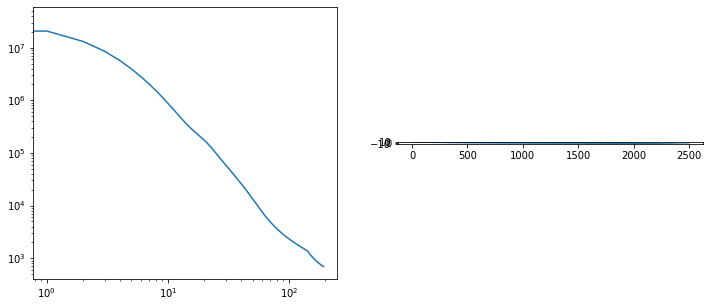

In [22]:
net = neuralHeat_Res([32,32, 1], A_sp, deepfdl=False, lr = 0.02)

net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
          early_stop_check_steps = 10, 
          min_steps=50, 
          gcn_stop_threshold = GCN_STOP_THRESHOLD,
          fdl_stop_threshold = FDL_STOP_THRESHOLD,
         )

figure(figsize=(12,5))
subplot(121)
plot(net.loss_history)
xscale('log')
yscale('log')
subplot(122, aspect='equal')
plot_layout(net)
print(net.loss_history[-1])

step: 152, Loss change ratio: 0.000391
stopping at step  151
train_reparametrization time: 0.217 s

FDL training 200000 steps
step: 204, Loss change ratio: 0.000222
stopping at step  51
train_fine time: 0.0357 s
train time: 0.254 s
972.96875


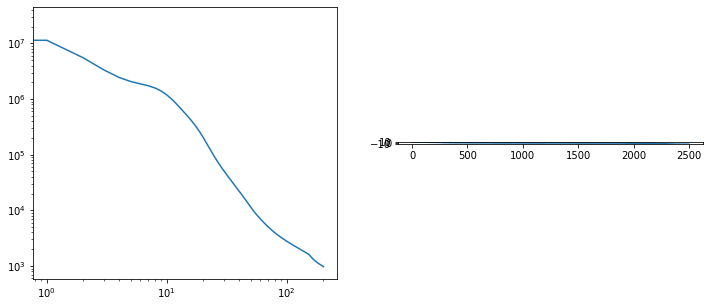

In [26]:
net = neuralHeat_Res([32,32, 1], A_sp, deepfdl=True, lr = 0.02)

net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
          early_stop_check_steps = 10, 
          min_steps=50, 
          gcn_stop_threshold = GCN_STOP_THRESHOLD,
          fdl_stop_threshold = FDL_STOP_THRESHOLD,
         )

figure(figsize=(12,5))
subplot(121)
plot(net.loss_history)
xscale('log')
yscale('log')
subplot(122, aspect='equal')
plot_layout(net)
print(net.loss_history[-1])

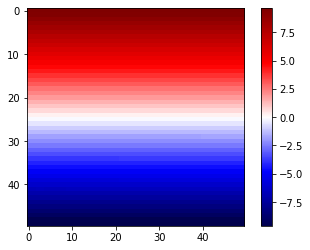

In [194]:
node_state = net.get_node_pos().detach().numpy()

imshow(np.reshape(node_state, (-1, int(sqrt(N)) )), cmap='seismic' )
colorbar();


FDL training 200000 steps
step: 7652, Loss change ratio: 0.00923
stopping at step  7651
train_fine time: 5.5 s
train time: 5.5 s
393.8336486816406


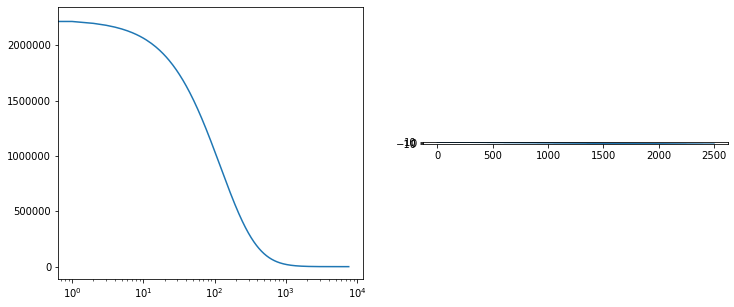

In [27]:
net = neuralHeat_Res([32, 32, 64, 1], A_sp, deepfdl=True, lr = 0.02)

net.train(gcn_steps=0, fdl_steps=MAX_FDL_STEPS, 
          early_stop_check_steps = 10, 
          min_steps=50, 
          gcn_stop_threshold = GCN_STOP_THRESHOLD,
          fdl_stop_threshold = FDL_STOP_THRESHOLD,
         )

figure(figsize=(12,5))
subplot(121)
plot(net.loss_history)
xscale('log')

subplot(122, aspect='equal')
plot_layout(net)
print(net.loss_history[-1])

In [197]:
linear_loss = net.loss_history

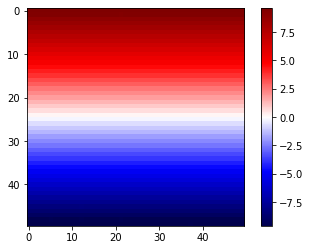

In [198]:
node_state = net.get_node_pos().detach().numpy()

imshow(np.reshape(node_state, (-1, int(sqrt(N)) )), cmap='seismic' )
colorbar();

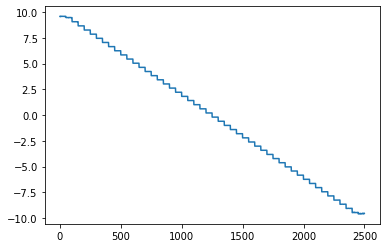

In [199]:
plot(node_state);

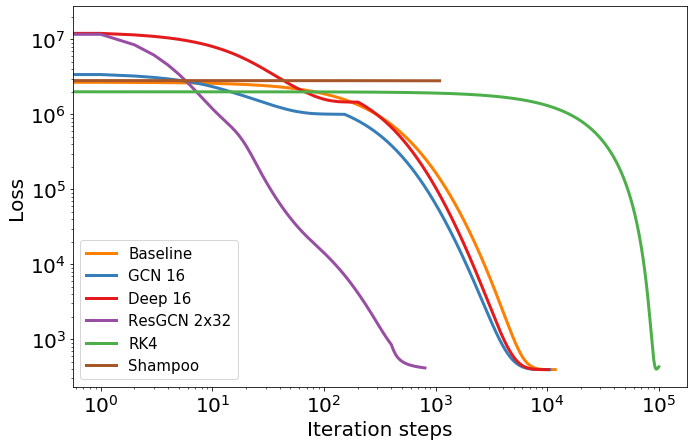

In [1158]:
figure(figsize = (11, 7))

plot(linear_loss,  c = c5, linewidth=3, label = 'Baseline')
plot(gcn_loss,  c = c2,linewidth=3 ,label = 'GCN 16')
plot(deep_loss, c = c1, linewidth=3 ,label = 'Deep 16')
plot(res32_loss, c = c4,linewidth=3,  label = 'ResGCN 2x32')
plot(y[1],  c = c3, linewidth=3,label = 'RK4')
plot(linear_shampoo_loss, c = c7, linewidth=3, label = 'Shampoo')
 
xlabel('iteration steps')
ylabel('loss')

xscale('log')
yscale('log')

plt.legend(loc=0, prop={"size":10});
plt.legend(fontsize=15);

xlabel('Iteration steps', fontname='sherif',size=20)
ylabel('Loss', fontname='sherif',size=20)

plt.xticks(fontname='sherif',size=20)
plt.yticks(fontname='sherif',size=20);

#plt.savefig('0916_heat_loss---.svg')

In [101]:
e=10

dimension = [8, 16, 32, 64, 128]

one_layer = []

for i in dimension:
    for j in range(e):
        
        start_time = time.time()
        net = neuralHeat_Res([i,i, 1], A_sp, deepfdl=False, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
       
        one_layer += [[ 'GCN Res', [i,i,1], time.time() - start_time, net.loss_history[-1] ]] 
        
        
        start_time = time.time()
        net = neuralHeat([i,i, 1], A_sp, deepfdl=False, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
        
        one_layer += [[ 'GCN', [i,i,1], time.time() - start_time, net.loss_history[-1] ]] 
        
        start_time = time.time()
        net = neuralHeat_Res([i,i, 1], A_sp, deepfdl=True, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
        
        one_layer += [[ 'Deep Res', [i,i,1], time.time() - start_time, net.loss_history[-1] ]] 
        
        start_time = time.time()
        net = neuralHeat([i,i, 1], A_sp, deepfdl=True, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
        
        one_layer += [[ 'Deep', [i,i,1], time.time() - start_time, net.loss_history[-1] ]] 
        

step: 392, Loss change ratio: 9.09e-05
stopping at step  391
train_reparametrization time: 1.08 s

FDL training 200000 steps
step: 3484, Loss change ratio: 0.001544
stopping at step  3091
train_fine time: 3.58 s
train time: 4.66 s
step: 382, Loss change ratio: 9.09e-05
stopping at step  381
train_reparametrization time: 0.921 s

FDL training 200000 steps
step: 2364, Loss change ratio: 0.000485
stopping at step  1981
train_fine time: 2.29 s
train time: 3.21 s
step: 492, Loss change ratio: 9.62e-05
stopping at step  491
train_reparametrization time: 0.834 s

FDL training 200000 steps
step: 1644, Loss change ratio: 7.18e-06
stopping at step  1151
train_fine time: 1.28 s
train time: 2.11 s
step: 962, Loss change ratio: 9.13e-05
stopping at step  961
train_reparametrization time: 1.46 s

FDL training 200000 steps
step: 2404, Loss change ratio: 0.000129
stopping at step  1441
train_fine time: 1.58 s
train time: 3.04 s
step: 502, Loss change ratio: 9.9e-056
stopping at step  501
train_reparam

In [987]:
e=10

dimension = [8, 16, 32, 64, 128]

two_layer = []


for i in dimension:
    for j in range(e):
        
        start_time = time.time()
        net = neuralHeat_Res([i,i,i, 1], A_sp, deepfdl=False, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
       
        two_layer += [[ 'GCN Res', [i,i,i,1], time.time() - start_time, net.loss_history[-1] ]] 
        
        
        start_time = time.time()
        net = neuralHeat([i,i,i, 1], A_sp, deepfdl=False, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
        
        two_layer += [[ 'GCN', [i,i,i,1], time.time() - start_time, net.loss_history[-1] ]] 
        
        start_time = time.time()
        net = neuralHeat_Res([i,i,i, 1], A_sp, deepfdl=True, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
        
        two_layer += [[ 'Deep Res', [i,i,i,1], time.time() - start_time, net.loss_history[-1] ]] 
        
        start_time = time.time()
        net = neuralHeat([i,i,i, 1], A_sp, deepfdl=True, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
        
        two_layer += [[ 'Deep', [i,i,i,1], time.time() - start_time, net.loss_history[-1] ]] 

step: 482, Loss change ratio: 9.85e-05
stopping at step  481
train_reparametrization time: 3.75 s

FDL training 200000 steps
step: 6914, Loss change ratio: 0.015347
stopping at step  6431
train_fine time: 14.6 s
train time: 18.4 s
step: 602, Loss change ratio: 9.71e-05
stopping at step  601
train_reparametrization time: 4.27 s

FDL training 200000 steps
step: 1874, Loss change ratio: 0.000102
stopping at step  1271
train_fine time: 2.77 s
train time: 7.04 s
step: 662, Loss change ratio: 9.7e-052
stopping at step  661
train_reparametrization time: 2.15 s

FDL training 200000 steps
step: 5884, Loss change ratio: 0.014488
stopping at step  5221
train_fine time: 11.3 s
train time: 13.5 s
step: 7132, Loss change ratio: 9.42e-05
stopping at step  7131
train_reparametrization time: 20.4 s

FDL training 200000 steps
step: 11674, Loss change ratio: 0.01527
stopping at step  4541
train_fine time: 9.94 s
train time: 30.3 s
step: 542, Loss change ratio: 9.68e-05
stopping at step  541
train_reparam

KeyboardInterrupt: 

In [ ]:
e=10

dimension = [8, 16, 32, 64, 128]

three_layer = []


for i in dimension:
    for j in range(e):
        
        start_time = time.time()
        net = neuralHeat_Res([i,i,i, i, 1], A_sp, deepfdl=False, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
       
        three_layer += [[ 'GCN Res', [i,i,i, i,1], time.time() - start_time, net.loss_history[-1] ]] 
        
        
        start_time = time.time()
        net = neuralHeat([i,i,i,i, 1], A_sp, deepfdl=False, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
        
        three_layer += [[ 'GCN', [i,i,i, i,1], time.time() - start_time, net.loss_history[-1] ]] 
        
        start_time = time.time()
        net = neuralHeat_Res([i,i,i,i, 1], A_sp, deepfdl=True, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
        
        three_layer += [[ 'Deep Res', [i,i,i, i,1], time.time() - start_time, net.loss_history[-1] ]] 
        
        start_time = time.time()
        net = neuralHeat([i,i,i, i, 1], A_sp, deepfdl=True, lr = 0.02)
        net.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
        
        three_layer += [[ 'Deep', [i,i,i, i,1], time.time() - start_time, net.loss_history[-1] ]] 

In [102]:
e=10

linear = []


for j in range(e):
        
    start_time = time.time()
    net = neuralHeat_Res([i,i,i, i, 1], A_sp, deepfdl=False, lr = 0.02)
    net.train(gcn_steps=0, fdl_steps=MAX_FDL_STEPS, early_stop_check_steps = 10, min_steps=50, gcn_stop_threshold = GCN_STOP_THRESHOLD, fdl_stop_threshold = FDL_STOP_THRESHOLD,)
       
    linear += [[ 'Baseline', [], time.time() - start_time, net.loss_history[-1] ]] 
        
    


FDL training 200000 steps
step: 2872, Loss change ratio: 0.000831
stopping at step  2871
train_fine time: 4.99 s
train time: 4.99 s

FDL training 200000 steps
step: 2762, Loss change ratio: 0.000628
stopping at step  2761
train_fine time: 4.72 s
train time: 4.72 s

FDL training 200000 steps
step: 2762, Loss change ratio: 0.000636
stopping at step  2761
train_fine time: 4.53 s
train time: 4.53 s

FDL training 200000 steps
step: 2942, Loss change ratio: 0.001074
stopping at step  2941
train_fine time: 4.73 s
train time: 4.73 s

FDL training 200000 steps
step: 2942, Loss change ratio: 0.000881
stopping at step  2941
train_fine time: 4.75 s
train time: 4.75 s

FDL training 200000 steps
step: 3032, Loss change ratio: 0.001252
stopping at step  3031
train_fine time: 4.56 s
train time: 4.56 s

FDL training 200000 steps
step: 2782, Loss change ratio: 0.000528
stopping at step  2781
train_fine time: 4.15 s
train time: 4.15 s

FDL training 200000 steps
step: 2782, Loss change ratio: 0.000562
st

In [109]:
linear = array(linear)

mean_time = mean(linear[:, 2])
mean_energy = mean(linear[:, 3])

std_time = std(linear[:, 2])
std_energy = std(linear[:, 3])



In [111]:
dl = pd.DataFrame(linear, columns = ['model', 'latent', 'time', 'energy'])
dl.to_csv('./result_11/linear_rand_50x50_01.csv', index = False)


In [112]:
onel = [ [i[0], str(i[1]), i[2],i[3] ] for i in one_layer]
#twol = [ [i[0], str(i[1]), i[2],i[3] ] for i in two_layer]
#threel = [ [i[0], str(i[1]), i[2],i[3] ] for i in three_layer]

In [113]:
d1 = pd.DataFrame(onel, columns = ['model', 'latent', 'time', 'energy'])
d1.time = mean_time / d1.time
d1.energy =  d1.energy/mean_energy

d1.to_csv('./result_11/one_layer_rand_50x50_01.csv', index = False)
d2 = pd.DataFrame(twol, columns = ['model', 'latent', 'time', 'energy'])

d2.time = mean_time / d2.time
d2.energy =  d2.energy/mean_energy

d2.to_csv('./result_11/two_layer_100x100_01.csv', index = False)
d3 = pd.DataFrame(threel, columns = ['model', 'latent', 'time', 'energy'])

d3.time = mean_time / d3.time
d3.energy =  d3.energy/mean_energy

d3.to_csv('./result_11/three_layer_100x100_01.csv', index = False)

In [114]:
d1[d1.model == 'GCN Res'].groupby('latent').mean()['energy']

latent
[128, 128, 1]    0.999999
[16, 16, 1]      0.999999
[32, 32, 1]      0.999999
[64, 64, 1]      0.999999
[8, 8, 1]        1.000000
Name: energy, dtype: float64

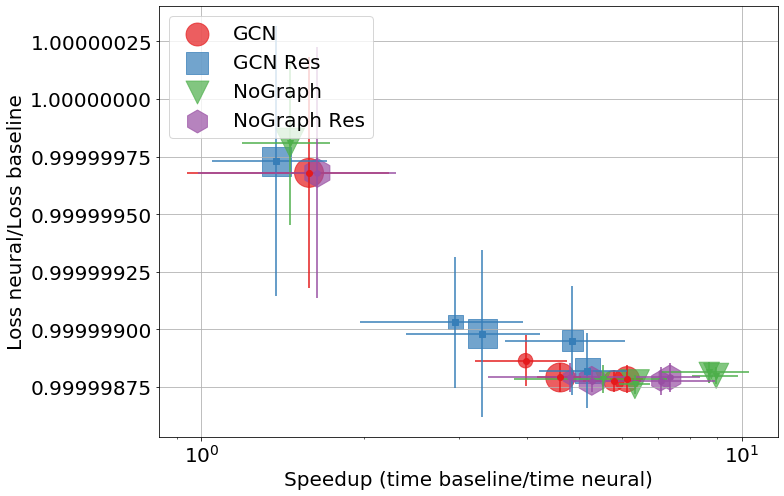

In [115]:
figure(figsize = (11, 7))
model = ['GCN', 'GCN Res', 'Deep', 'Deep Res']
name = {'GCN':'GCN', 'GCN Res': 'GCN Res', 'Deep': 'NoGraph', 'Deep Res':'NoGraph Res'}
color = {'GCN': c1, 'GCN Res':c2, 'Deep':c3, 'Deep Res':c4}
shape = {'GCN': 'o', 'GCN Res':'s', 'Deep':'v', 'Deep Res':'h'}
size = array([120, 30, 60, 90])

for i in model:
    x = array(d1[d1.model == i].groupby('latent').mean()['time'])
    y =array(d1[d1.model == i].groupby('latent').mean()['energy'])
    xe = array(d1[d1.model == i].groupby('latent').std()['time'])
    ye = array(d1[d1.model == i].groupby('latent').std()['energy'])
    
    
    errorbar( x, y, xerr = xe,  yerr = ye ,color = color[i],marker = shape[i], fmt="o")
    scatter( x, y ,marker = shape[i], color = color[i], s = size*7,  label = name[i] , alpha = .7)
    
    
plt.legend(loc=2, prop={"size":20} , ncol= 1);

grid(zorder=0)   
    
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
xscale('log')
#yscale('log')

#ylim(0.9992, 1.0007)
#xlim(1, 20)

xlabel('Speedup (time baseline/time neural)', fontname='sherif',size=20)
ylabel('Loss neural/Loss baseline', fontname='sherif',size=20)

plt.xticks(fontname='sherif',size=20)
plt.yticks(fontname='sherif',size=20);

#title('Heat equation on 2D lattice (50x50)', fontname='sherif',size=20);



plt.tight_layout();

plt.savefig('./result_11/1_onleyar_heat_random_50_01.svg');

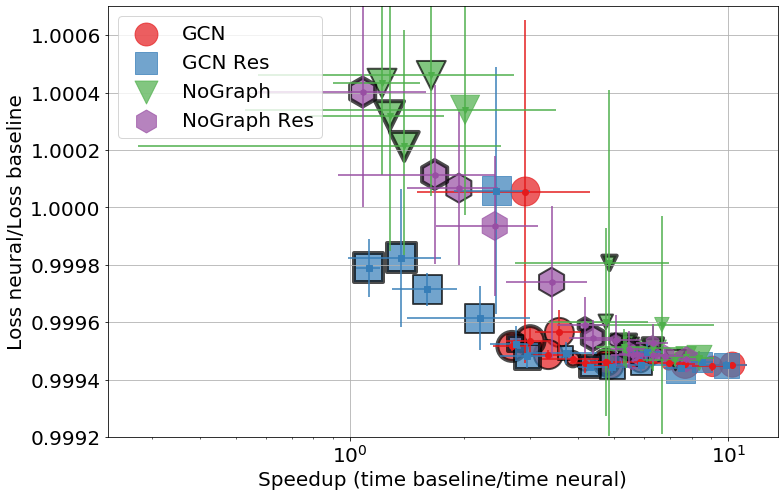

In [957]:
figure(figsize = (11, 7))
model = ['GCN', 'GCN Res', 'Deep', 'Deep Res']
name = {'GCN':'GCN', 'GCN Res': 'GCN Res', 'Deep': 'NoGraph', 'Deep Res':'NoGraph Res'}
color = {'GCN': c1, 'GCN Res':c2, 'Deep':c3, 'Deep Res':c4}
shape = {'GCN': 'o', 'GCN Res':'s', 'Deep':'v', 'Deep Res':'h'}
size = array([120, 30, 60, 90])

for i in model:
    x = array(d1[d1.model == i].groupby('latent').mean()['time'])
    y =array(d1[d1.model == i].groupby('latent').mean()['energy'])
    xe = array(d1[d1.model == i].groupby('latent').std()['time'])
    ye = array(d1[d1.model == i].groupby('latent').std()['energy'])
    
    
    errorbar( x, y, xerr = xe,  yerr = ye ,color = color[i],marker = shape[i], fmt="o")
    scatter( x, y ,marker = shape[i], color = color[i], s = size*7,  label = name[i] , alpha = .7)
    
    x = array(d2[d2.model == i].groupby('latent').mean()['time'])
    y =array(d2[d2.model == i].groupby('latent').mean()['energy'])
    xe = array(d2[d2.model == i].groupby('latent').std()['time'])
    ye = array(d2[d2.model == i].groupby('latent').std()['energy'])
    
    
    errorbar( x, y, xerr = xe,  yerr = ye ,color = color[i],marker = shape[i], fmt="o")
    scatter( x, y ,marker = shape[i], color = color[i],edgecolor='black',linewidths=2 , s = size*7,   alpha = .7)
    
    
    x = array(d3[d3.model == i].groupby('latent').mean()['time'])
    y =array(d3[d3.model == i].groupby('latent').mean()['energy'])
    xe = array(d3[d3.model == i].groupby('latent').std()['time'])
    ye = array(d3[d3.model == i].groupby('latent').std()['energy'])
    
    errorbar( x, y, xerr = xe,  yerr = ye ,color = color[i],marker = shape[i], fmt="o")
    scatter( x, y ,marker = shape[i], color = color[i],edgecolor='black',linewidths=4 , s = size*7 , alpha = .7)
    
    
plt.legend(loc=2, prop={"size":20} , ncol= 1);

grid(zorder=0)   
    
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
xscale('log')
#yscale('log')

ylim(0.9992, 1.0007)
#xlim(1, 20)

xlabel('Speedup (time baseline/time neural)', fontname='sherif',size=20)
ylabel('Loss neural/Loss baseline', fontname='sherif',size=20)

plt.xticks(fontname='sherif',size=20)
plt.yticks(fontname='sherif',size=20);

#title('Heat equation on 2D lattice (50x50)', fontname='sherif',size=20);



plt.tight_layout();

#plt.savefig('./result_11/1_multilayer_heat_50_01.svg');